# Climatological Anomalies

In this tutorial, we'll look at how to use wxee to calculate long-term climatological anomalies with gridded weather data. Anomalies represent the difference between an observation and the long-term climatological mean for a given day or month. 

## Setup

In [ ]:
!pip install wxee

In [1]:
import ee
import wxee

ee.Authenticate()
wxee.Initialize()

## June 2021 Heat Wave
In late June of 2021, the Pacific Northwest of North America experienced an historic heat wave that broke many temperature records. Calculating monthly max temperature anomalies for this period will highlight just how unusual the observed weather was.

### Reference and Observation Data

To start, we'll load a `TimeSeries` of daily temperature data from [gridMET](http://www.climatologylab.org/gridmet.html).

In [2]:
temp = wxee.TimeSeries("IDAHO_EPSCOR/GRIDMET").select("tmmx")

Next, we'll split our `TimeSeries` into two periods. 

The first `TimeSeries` will be our 30-year reference period for calculating long-term climatological normals. We'll use this as a baseline to identify anomalies during the heat wave.

In [3]:
ref = temp.filterDate("1980", "2010")

The second `TimeSeries` is our observation period, spanning about five months around the June heat wave.

In [4]:
obs = temp.filterDate("2021-04", "2021-09")

### Climatological Mean

Now we can calculate the monthly climatological mean temperature over our reference period. We'll use `ee.Reducer.max()` to get the maximum daily temperature in each month. 

In [5]:
mean_clim = ref.climatology_mean("month", reducer=ee.Reducer.max())

### Climatological Anomaly

Now we'll calculate monthly temperature anomalies within our observation period based on the climatological means from our reference period. 

The same `frequency` and `reducer` used in by `mean_clim` will be applied to the climatology anomaly.

In [6]:
anom = obs.climatology_anomaly(mean=mean_clim)

Download the data to an `xarray.Dataset`.

In [7]:
ds = anom.wx.to_xarray(crs="EPSG:5070", scale=20_000)

Requesting data:   0%|          | 0/5 [00:00<?, ?it/s]

Plotting the monthly data, we can see that maximum temperatures in June in the Pacific Northwest exceeded long-term climatological normals by more than **15 °C**!

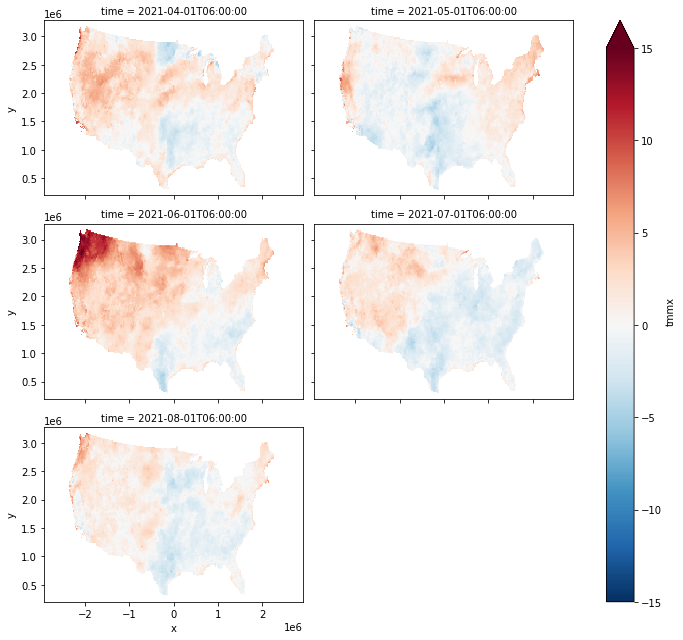

In [8]:
ds.tmmx.plot(
    col="time", col_wrap=2, aspect=1.5, 
    vmin=-15, vmax=15, 
    cmap="RdBu_r"
)

### Standardized Anomalies

Standardized anomalies, which represent the number of standard deviations that an observation differed from the long-term mean, can also be calculated with `wxee`. Just calculate a long-term climatological standard deviation using `TimeSeries.climatology_std` and pass that to the `std` argument!

In [9]:
std_clim = ref.climatology_std("month", reducer=ee.Reducer.max())

std_anom = obs.climatology_anomaly(
    mean=mean_clim, 
    std=std_clim, 
)

Download to an `xarray.Dataset`.

In [10]:
std_ds = std_anom.wx.to_xarray(crs="EPSG:5070", scale=20_000)

Requesting data:   0%|          | 0/5 [00:00<?, ?it/s]

And plot! The data looks similar to above, but now we know that the ~15 °C anomalies that we saw above were more than **4 standard deviations** hotter than the long-term mean!

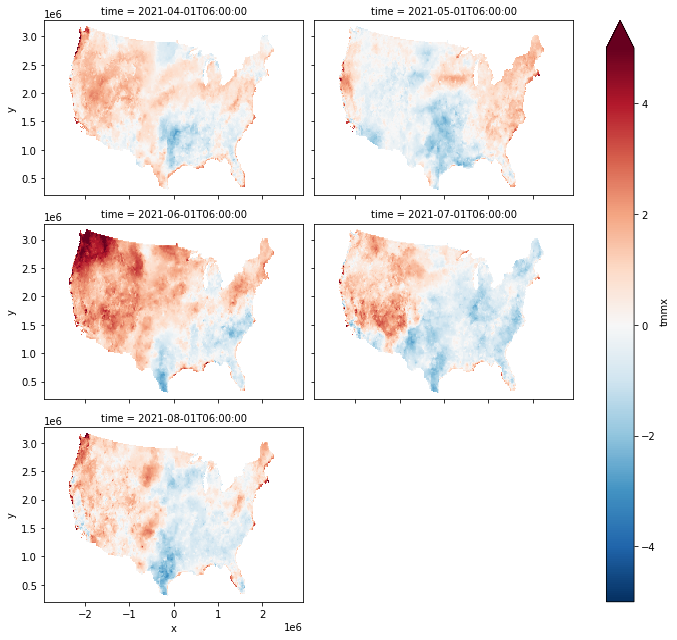

In [11]:
std_ds.tmmx.plot(
    col="time", col_wrap=2, aspect=1.5, 
    vmin=-5, vmax=5, 
    cmap="RdBu_r"
)